In [ ]:
# Following script combines the annotation data with the time series data
path = r'C:\Users\Grover\Documents\GitHub\EZLabel\true_annotations'
dict_path = r'Z:\mfk\basty-projects\tmp_results\predictions\ProboscisPumping\bouts_dict.pkl'

import pandas as pd
import os
import glob


def process_row(row, dictionary, N):
    df_dict = dictionary[row['name']]
    df_dict_filtered = df_dict.drop(['start_index', 'stop_index', 'region'], axis=1)

    trial_id = int(row['trial_id'])
    peak_index = row['peak_index']

    # New dictionary to store sliced data with column names
    sliced_data_dict = {}

    for col in df_dict_filtered.columns:
        if peak_index-N >= 0 and peak_index+N <= len(df_dict_filtered.loc[trial_id, col]):
            start = max(0, peak_index - N)
            end = min(len(df_dict_filtered.loc[trial_id, col]), peak_index + N)
            sliced_data_dict[col] = df_dict_filtered.loc[trial_id, col][start:end]

    return sliced_data_dict


In [ ]:

pkl_files = glob.glob(os.path.join(path, '*.pkl'))
ts_dict = pd.read_pickle(dict_path)

df_list = []  # A list to store each DataFrame


for file in pkl_files:
    data = pd.read_pickle(file)
    df = pd.DataFrame(data)
    df['name'] = os.path.splitext(os.path.basename(file))[0]
    df_list.append(df)  # Append the DataFrame to the list

# Concatenate all the DataFrames in the list into a single DataFrame
annotations = pd.concat(df_list, ignore_index=True)

# Rename the columns to make it more intuitive
annotations.rename(columns = {'index':'peak_index','column':'trial_id'},inplace=True)

In [ ]:
annotations

In [ ]:
annotations

In [ ]:
# Create an empty DataFrame to store all the processed rows
processed_data_df = pd.DataFrame()

# Initialize a counter for slice
slice_counter = 0

# Loop through each row in annotations
for i, row in annotations.iterrows():
    processed_row = process_row(row, ts_dict, 30)

    # Create a DataFrame for this row
    row_df = pd.DataFrame(processed_row)

    # Add 'slice_id' to the DataFrame
    row_df['slice_id'] = slice_counter

    # Set a multi-index using 'name', 'slice_id' and the existing index of row_df
    row_df.index = pd.MultiIndex.from_tuples([(row['name'], slice_counter, i) for i in row_df.index],
                                             names=['name', 'slice_id', 'time'])

    # Append it to processed_data_df
    processed_data_df = pd.concat([processed_data_df, row_df])

    # Increment the slice_counter
    slice_counter += 1


In [ ]:
import numpy as np
# Create a dictionary where key is (name, slice_id) and value is the sub-DataFrame
df_dict = dict(tuple(processed_data_df.groupby(level=['name', 'slice_id'])))

# Initialize an empty list to store each 2D array
array_list = []

# Loop over the dictionary
for key in df_dict:
    # Convert each DataFrame to a 2D numpy array and append to list
    array_list.append(df_dict[key].values)

# Convert list of arrays to a 3D numpy array
np_array = np.stack(array_list)


In [ ]:
output_path = r'C:\Users\Grover\Documents\GitHub\EZLabel'

processed_data_df.to_pickle(os.path.join(output_path,'false_peak_annotations.pkl'))

In [ ]:
np.save(os.path.join(output_path,'false_peak_annotations.npy'),np_array)

In [ ]:
output_path = r'C:\Users\Grover\Documents\GitHub\EZLabel\true_annotations\output'
annotations.to_pickle(os.path.join(output_path,'true_annotations.pkl'))

In [1]:
import pandas as pd
import os

# Load annotations and experimental info: 
path = r'C:\Users\Grover\Documents\GitHub\EZLabel\true_annotations'
annotations = pd.read_pickle(os.path.join(path,'output','true_annotations.pkl'))
expt_info_df_path = r'Z:\mfk\basty-projects\expt_info_df.pkl'
expt_info_df = pd.read_pickle(expt_info_df_path)

# Fetch all .mp4 files from the directory
directory = r'Y:\DeepSleepPaperData\Annotated\PredictedVideos\Pumping'
file_names = [f for f in os.listdir(directory) if f.endswith('.mp4')]

# Process each filename
data = []

for file in file_names:
    parts = file.split("_")

    index_position = parts.index('index')
    name = "_".join(parts[:index_position])
    trial_id = int(parts[index_position + 1])
    start = int(parts[parts.index('start') + 1])

    data.append([name, trial_id, start])

# Construct the DataFrame
df = pd.DataFrame(data, columns=["name", "trial_id", "start"])

annotations['trial_id'] = annotations['trial_id'].astype('int64')
df['trial_id'] = df['trial_id'].astype('int64')
merged_df = annotations.merge(df[['name', 'trial_id', 'start']], on=['name', 'trial_id'], how='left')

merged_df['pump_pos'] = merged_df['peak_index'] + merged_df['start']

In [ ]:
expt_info_df

In [2]:
name_to_sd = dict(zip(expt_info_df['ExptNames'], expt_info_df['SD']))
name_to_sex = dict(zip(expt_info_df['ExptNames'], expt_info_df['Sex']))

df = merged_df

# Split df into two based on SD value
df_sd_true = df[df['name'].map(name_to_sd)]
df_sd_false = df[~df['name'].map(name_to_sd)]

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

# Helper function to plot given a subset of df
def plot_data(subset_df, color, sd, sex):
    fig, ax = plt.subplots(figsize=(15, len(subset_df['name'].unique()) / 4))
    unique_names = subset_df['name'].unique()

    for idx, name in enumerate(unique_names):
        sub_subset_df = subset_df[subset_df['name'] == name]
        for _, row in sub_subset_df.iterrows():
            pump_pos = row['pump_pos']
            ax.barh(idx, 60, left=pump_pos - 30, color=color, edgecolor='none')

    fly_labels = [f"Fly{i+1}" for i in range(len(unique_names))]
    ax.set_yticks(range(len(unique_names)))
    ax.set_yticklabels(fly_labels)

    ZT_ticks, ZT_ticklabels = generate_tick_data(30, sd=sd)
    ax.set_xticks(ZT_ticks)
    ax.set_xticklabels(ZT_ticklabels)

    # Set x-axis limits to the beginning and end of the x-ticks
    ax.set_xlim(ZT_ticks[0], ZT_ticks[-1])

    title = f'SD_True_{sex}' if sd else f'SD_False_{sex}'
    ax.set_title(title)

    plt.tight_layout()
    plt.savefig(f'Pump_Positions_{title}.pdf')
    plt.show()


# Function to plot data for SD = True
def plot_sd_true():
    df_sd_true = df[df['name'].map(name_to_sd)]
    plot_data(df_sd_true, '#377eb8', sd=True)


# Function to plot data for SD = False
def plot_sd_false():
    df_sd_false = df[~df['name'].map(name_to_sd)]
    plot_data(df_sd_false, '#d62728', sd=False)
    
def plot_sub_data(df, expt_info_df, sd, sex,plot_it):
    # Create mappings from expt_info_df
    name_to_sd = dict(zip(expt_info_df['ExptNames'], expt_info_df['SD']))
    name_to_sex = dict(zip(expt_info_df['ExptNames'], expt_info_df['Sex']))
    
    # Filter based on provided sd and sex values
    sub_df = df[(df['name'].map(name_to_sd) == sd) & (df['name'].map(name_to_sex) == sex)]
    
    if plot_it:
        plot_data(sub_df, '#d62728', sd=sd,sex=sex)
    
    return sub_df,sd,sex
    
def generate_tick_data(FPS=30, sd=False):

    if sd == False:
        xticks = np.arange(
            start=0, stop=FPS * 60 * 60 * 16 + 1, step=FPS * 60 * 60 * 2
        )
        ZT_ticks = xticks
        ZT_ticklabels = [
            "ZT" + str((tick + 10) % 24) for tick in range(0, len(xticks) * 2, 2)
        ]
    else:
        xticks = np.arange(
            start=0, stop=FPS * 60 * 60 * 6 + 1, step=FPS * 60 * 60 * 1
        )
        ZT_ticks = xticks
        ZT_ticklabels = [
            "ZT" + str(tick) for tick in range(0, len(xticks) * 1, 1)
        ]

    return ZT_ticks, ZT_ticklabels


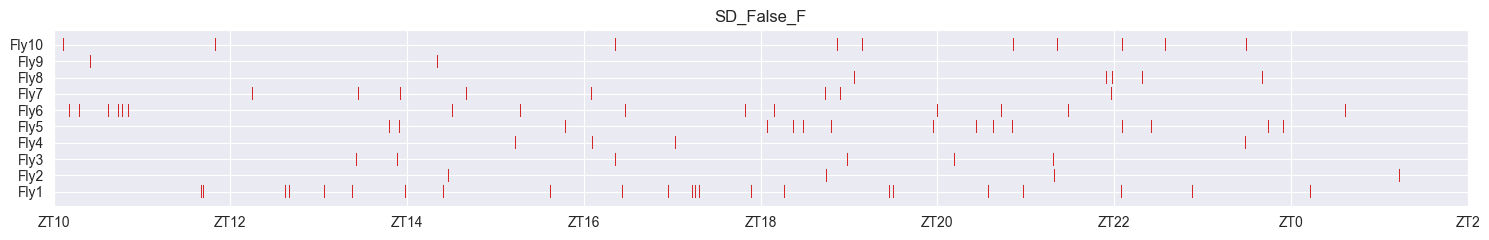

,peak_index,value,trial_id,name,start,pump_pos
157,1362,566.415327,0,Fly05202022_5d,175813,177175
158,1454,536.827060,0,Fly05202022_5d,175813,177267
159,533,485.680718,1,Fly05202022_5d,178307,178840
160,572,512.966567,3,Fly05202022_5d,182461,183033
161,657,496.870685,3,Fly05202022_5d,182461,183118
...,...,...,...,...,...,...
8041,1007,659.928192,55,Fly08012022_6d_B,1474683,1475690
8042,1100,659.267892,55,Fly08012022_6d_B,1474683,1475783
8043,1197,655.699800,55,Fly08012022_6d_B,1474683,1475880
8044,931,654.759026,56,Fly08012022_6d_B,1500629,1501560


In [12]:
plot_sub_data(df,expt_info_df,sd=False,sex='F')

In [34]:
import pandas as pd

def plot_bin_data(sub_df,sd,sex):
    plot_Df = sub_df
    # Convert pump_pos to minutes
    plot_Df['pump_pos_minutes'] = plot_Df['pump_pos'] / (30 * 60)
    
    # Define bin edges for 60-minute intervals
    max_minutes = plot_Df['pump_pos_minutes'].max()
    bins = list(range(0, int(max_minutes) + 61, 60))
    
    # For each unique 'name', bin the data and count values in each bin
    binned_data = {}
    for name, group in plot_Df.groupby('name'):
        binned_data[name] = pd.cut(group['pump_pos_minutes'], bins=bins).value_counts()
    
    # Convert the binned_data dictionary to a DataFrame
    binned_df = pd.DataFrame(binned_data).T
    binned_df = binned_df.fillna(0).astype(int)  # Replace NaN values with zeros and convert to integer type
    
    # Calculate the average for each bin across all "names"
    melted_df = binned_df.melt(var_name='Time Bin', value_name='Average Count')
    
    import seaborn as sns

    # Create the boxplot using seaborn
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=melted_df, x='Time Bin', y='Average Count', showfliers=False, color="skyblue", width=0.5, notch=False, boxprops=dict(edgecolor='none'))
  # Adjusted box width and color
    
    # Calculate the median values for each time bin and plot them
    medians = melted_df.groupby('Time Bin')['Average Count'].median()
    plt.plot(range(len(medians)), medians, color='black', linestyle='-', marker='o')
    
    # Set the x-tick labels to your ZT values
    if ~sd:
        ZT_labels = [f"ZT{((i + 10) % 24)}" for i in range(len(medians))]
        plt.xticks(ticks=range(len(ZT_labels)), labels=ZT_labels, rotation=45)
    else:
        ZT_labels = [f"ZT{((i))}" for i in range(len(medians))]
        plt.xticks(ticks=range(len(ZT_labels)), labels=ZT_labels, rotation=45)
        
    
    # Set y-label
    plt.ylabel("Pump per Hour")

    
    title = f"Avg_Binned_SD_{sd}_sex{sex}"
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f'{title}.pdf')
    plt.show()

In [43]:
sub,sd,sex = plot_sub_data(df,expt_info_df,sd=True,sex='F',plot_it=False)

C:\Users\Grover\AppData\Local\Temp\ipykernel_30132\3839114371.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_Df['pump_pos_minutes'] = plot_Df['pump_pos'] / (30 * 60)


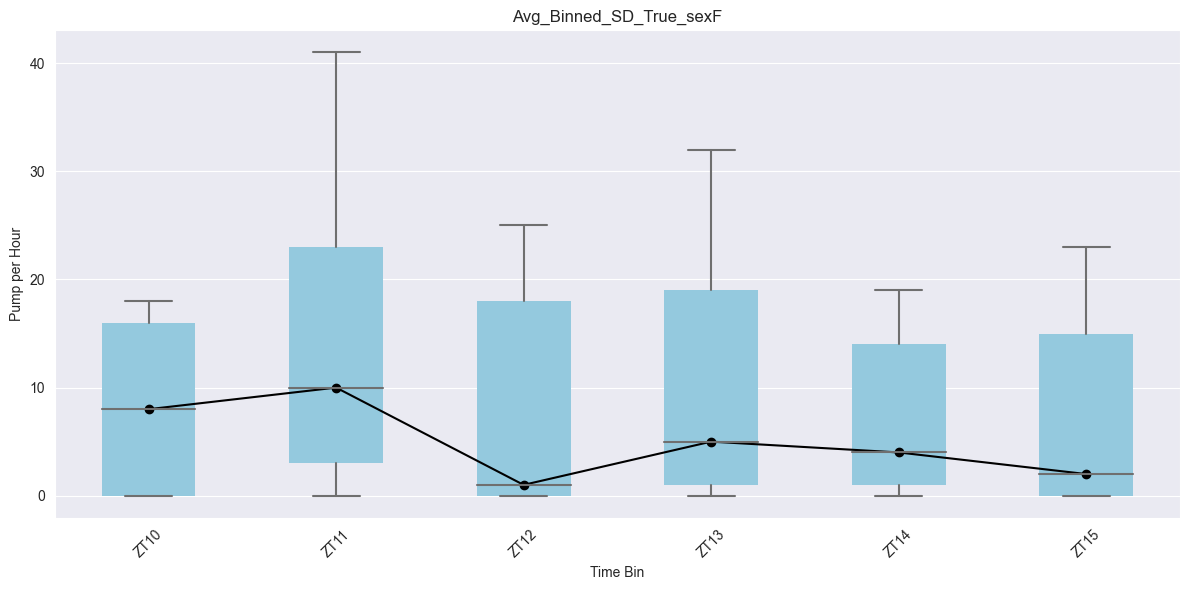

In [44]:
plot_bin_data(sub,sd,sex)